# OrionMonoceros test with method 1

In [1]:
%matplotlib inline

import os
import sys
import copy
import numpy as np

# filtering Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
from hdmclouds_v1 import *
from utils import *
from graph import *
from preprocessing import *
from gmr import *

from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider
import matplotlib
import matplotlib.pyplot as plt; plt.show()
matplotlib.rcParams.update({'font.size': 13})

#from pycupid import *
def load_data(fits_path):
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs = WCS(hdu.header)

    if data.ndim>3:
        # droping out the stokes dimension
        data = np.ascontiguousarray(data[0])
        wcs = wcs.dropaxis(3)

        if data.shape[0]==1:
            # in case data is not a cube but an image
            data = np.ascontiguousarray(data[0])
            wcs = wcs.dropaxis(2)
    
    # in case NaN values exist on data
    mask = np.isnan(data)
    if np.any(mask): data = ma.masked_array(data, mask=mask)

    return data,wcs,hdu

save_path = "/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/HDMC-v1/figures/"

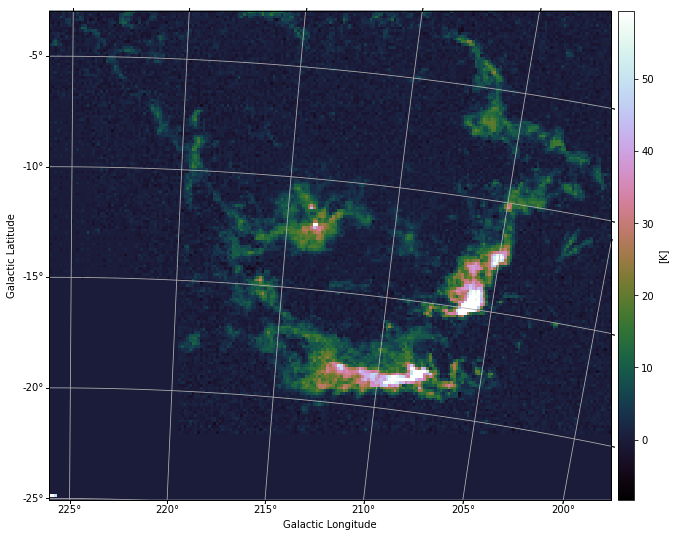

In [2]:
#fits_path = '../data/images/Orion.cont.image.fits'
#fits_path = '../data/images/OphA_ExtnCambR_F.fits'
#fits_path = '../data/images/PerA_Extn2MASS_F_Gal.fits'
#fits_path = '../data/images/RhoOphiuchus60.fits'
#fits_path = '../data/images/perseus60.fits'
fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

data,wcs,hdu = load_data(fits_path)
base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"], save_path="./orion_12CO_mom0.png")

In [3]:
preprocessing(data, wcs)

interactive(children=(FloatSlider(value=6.833755925097559, description='back_level', max=13.667511850195117, m…

## Pre - Initial Guess Generation
1. We cluster the set of _significant emission pixels_ into set of contiguous pixels. These regions are named Independent Cloud Entities (ICE).
2. This is done with DBSCAN algorithm.
3. From now on, each ICE is treated independently.

## Initial Guess Algorithm.
1. We start with a mixture of Gaussians with 1 Gaussian per pixel. 
    a. The weights $w_i$ are set to the intensity value of the pixel in which the $i$-th Gaussian is centered.
    b. The $\sigma_i$ are set such that there is a minimum overlap between Gaussians.
2. We reduce the number mixture Gaussian with KL-GMR algorithm, until we reach a defined (parameter `n_gaussians`) number of components in the mixture.
3. The initial guess is good enough, and produces a good distribution of Gaussian center points.

[INFO] Number of pixels with significant emission: 6013
[INFO] Level of compression: 6.652253450856478%
[INFO] Number of ICEs: 14
Isolated Cloud Entity A: 4359 pixels of significant emission.
Isolated Cloud Entity B: 44 pixels of significant emission.
Isolated Cloud Entity C: 31 pixels of significant emission.
Isolated Cloud Entity D: 41 pixels of significant emission.
Isolated Cloud Entity E: 169 pixels of significant emission.
Isolated Cloud Entity F: 71 pixels of significant emission.
Isolated Cloud Entity G: 295 pixels of significant emission.
Isolated Cloud Entity H: 743 pixels of significant emission.
Isolated Cloud Entity I: 27 pixels of significant emission.
Isolated Cloud Entity J: 34 pixels of significant emission.
Isolated Cloud Entity K: 120 pixels of significant emission.
Isolated Cloud Entity L: 21 pixels of significant emission.
Isolated Cloud Entity M: 24 pixels of significant emission.
Isolated Cloud Entity N: 34 pixels of significant emission.


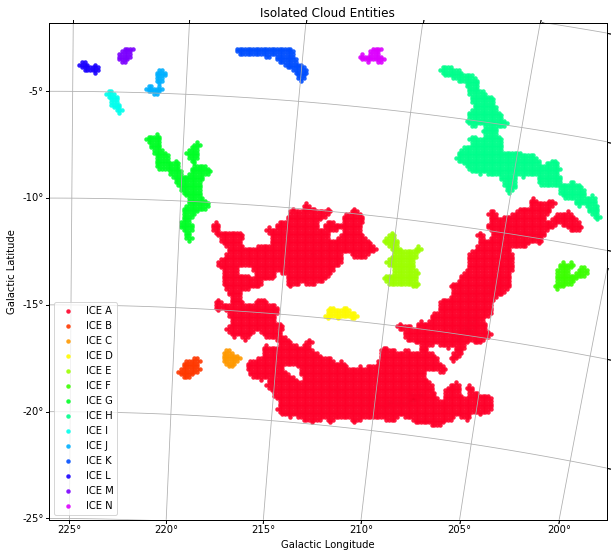

####################################################################################################


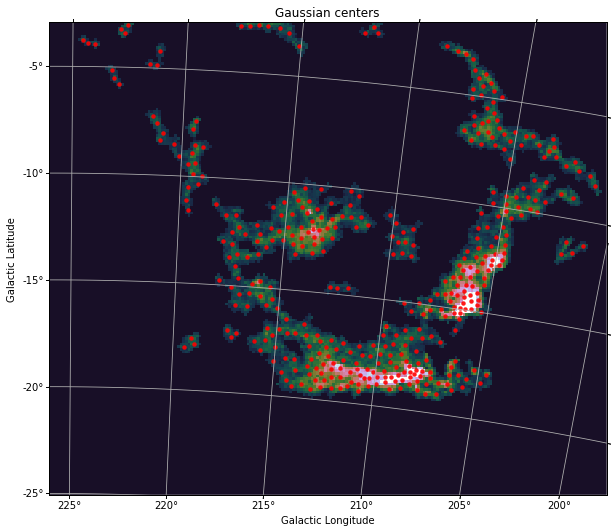

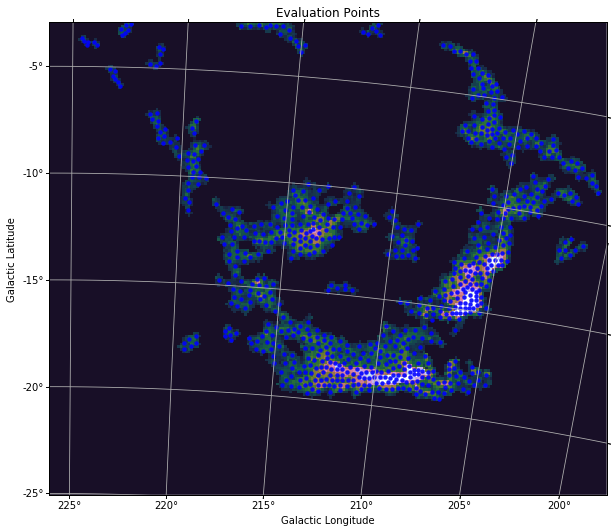

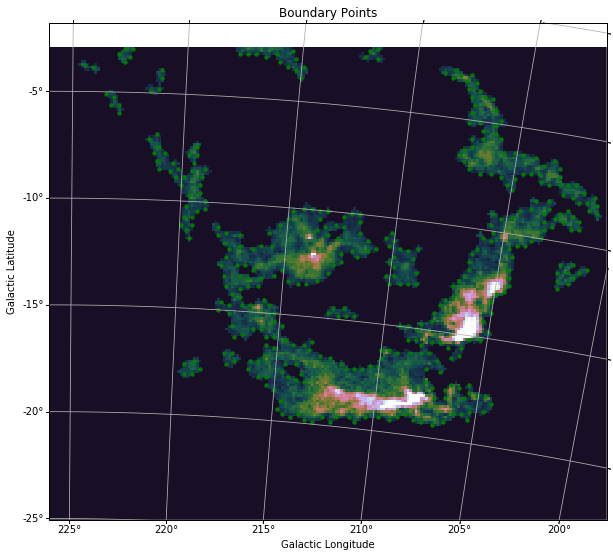

In [4]:
hdmc = HDMClouds(data, back_level=1.5, wcs=wcs, verbose=True, n_gaussians=400)

### Faster GMR approach

To avoid this being the new bottleneck, a lot of improvements were made:

Let $N$ be the number of Gaussian components in the mixture $u$, and $k$ the (mean/maximum) number of neighbors of a single Gaussian  component. 

Dissimilarity matrix (`diss_matrix`) stores the dissimilarity (`KLdiv`) between the components. `nn_indexes` stores the neighbors for each of the _alive_ component in the mixture.  

1. Compute neighbors (`nn_indexes`): $O(N \log N)$.
2. Compute the dissimilarity matrix (`diss_matrix`): $K_{N \times k}$: $O(Nk)$.
3. Inside the main loop:
    1. Find the least dissimilar components: $O(N)$ (done in parallel).
    2. Update indexes of _alive_ components: $O(1)$.
    3. Radius search for the new component: $O(\log(N))$.
    4. Update structs (`nn_indexes` and `diss_matrix`): $O(Nk)$ + $O(k)$. (done in parallel)

Note that $k<<N$. For 2D $ \ k \sim 10$and for 3D $\ k \sim 30$. 

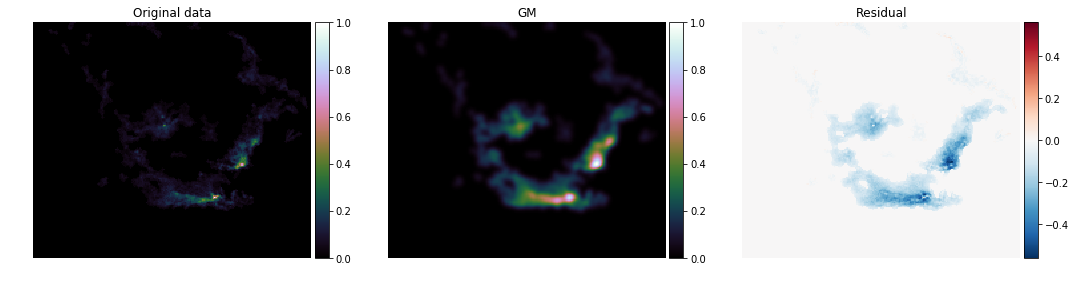

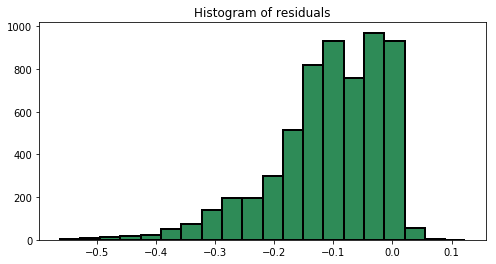

RESIDUAL STATS
RMS of residual: 0.057797142538124895
Inf norm of residual: 0.5626673727647642
Variance of residual: 0.0030376111569272446
Normalized flux addition: 1.5163121524128997
Normalized flux lost: 0.0111855912304061


In [5]:
hdmc.get_residual_stats();

### Gaussian Mixture Refinement.

_Remember that each ICE is trated independently_

1. Variational formulation.
2. Bounded LM optimization.

This was the main __bottleneck__ in the previous HDMC implementation. This was addressed with a _fast gaussian mixture evaluation_

1. For each Gaussian in the mixture, we compute the set of evaluation points in a near-neighborhood to that mixture. Only on this neighborhood the Gaussian will have effect (_forced_ compact support). 
2. Lets define $\sigma_{\text{max}}$ as the maximal obtained after the IG generation. The radio of neighborhood is set to $r = 5 \sigma_{\text{max}}$.
3. Furthermore, the evaluation of the GM in the evaluation points is parallelized.

Smaller problems + Efficient evaluation of GM in neighorhoods + Parallelization __->__ Huge computational improvement.

In [6]:
%%prun -s tottime -q -l 30 -T hdmc_m1.prof
hdmc.build_gmr()

---------------------------------------------
Building GM for Isolated Cloud Entity A
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.026086233155771285
Inf norm of residual: 0.42614067459488614
Variance of residual: 0.0006583966372887211
Normalized flux addition: 0.1356524472529834
Normalized flux lost: 0.07647064521779373


---------------------------------------------
Building GM for Isolated Cloud Entity B
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.012048188716692708
Inf norm of residual: 0.036490710443188905
Variance of residual: 0.00014472542890629563
Normalized flux addition: 0.09178147700033827
Normalized flux lost: 0.10549969911942939


---------------------------------------------
Building GM for Isolated Cloud Entity C
---------------------------------------------
RESIDUAL STATS
RMS of residual: 0.010815393816619044
Inf norm of residual: 0.032959687033128855
Variance of residual: 0.00011061262271637439
Norm

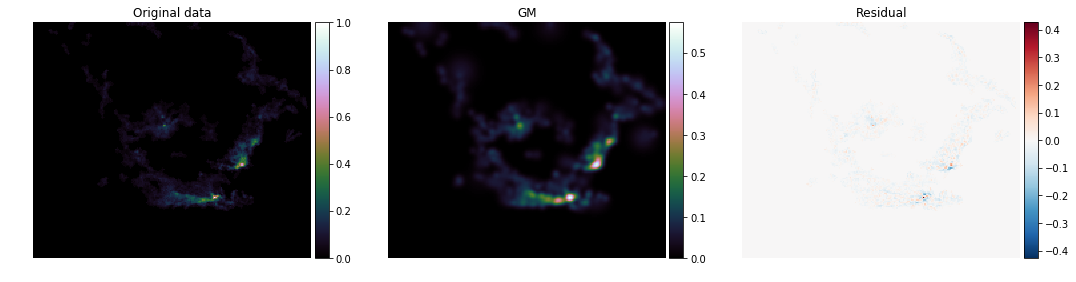

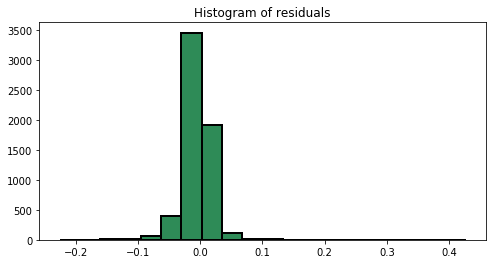

RESIDUAL STATS
RMS of residual: 0.009456925736586446
Inf norm of residual: 0.426140674594886
Variance of residual: 8.893043181071588e-05
Normalized flux addition: 0.13812378838677328
Normalized flux lost: 0.07678801300142009


In [7]:
hdmc.get_residual_stats();

In [8]:
print("Elapsed time {0}".format(hdmc.elapsed_time))

Elapsed time 182.10451006889343


In [9]:
w,sig = hdmc.get_params()

print("PARAMETERS VARIATION:")
print("w variation: ",np.max(np.abs(hdmc.w0-w)))
print("sig variation: ",np.max(np.abs(hdmc.sig0-sig)))

PARAMETERS VARIATION:
w variation:  0.22257524366088446
sig variation:  0.026176575691490477


#### Profiling results

In [10]:
print(open('hdmc_m1.prof', 'r').read())

         870415 function calls in 182.105 seconds

   Ordered by: internal time
   List reduced from 109 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   288064  119.733    0.000  119.733    0.000 {fgm_eval.gm_eval2d_2}
       14   50.634    3.617  182.062   13.004 {built-in method scipy.optimize._minpack._lmdif}
   144025    6.788    0.000  131.437    0.001 hdmclouds_v1.py:965(F)
   144053    3.594    0.000    3.594    0.000 utils.py:132(sig_mapping)
   144041    1.273    0.000    1.273    0.000 {built-in method numpy.core.multiarray.concatenate}
   144128    0.056    0.000    0.056    0.000 {built-in method builtins.len}
       22    0.007    0.000    0.007    0.000 {built-in method numpy.core.multiarray.dot}
       11    0.006    0.001    0.007    0.001 basic.py:907(inv)
      286    0.002    0.000    0.002    0.000 socket.py:334(send)
       14    0.001    0.000    0.014    0.001 hdmclouds_v1.py:893(get_residual_stats)
      

***

### Building the hierarchical tree

1. A binary hierarchical tree is built for each ICE.
2. This is done using the GMR algorithm with KL-divergence measure.
3. The agglomerations goes on until the mixuture is composed only by 1 Gaussian.

In [11]:
hdmc.build_hierarchical_tree()

Building the hierarchical tree for Isolated Cloud Entity A
DONE

Building the hierarchical tree for Isolated Cloud Entity B
DONE

Building the hierarchical tree for Isolated Cloud Entity C
DONE

Building the hierarchical tree for Isolated Cloud Entity D
DONE

Building the hierarchical tree for Isolated Cloud Entity E
DONE

Building the hierarchical tree for Isolated Cloud Entity F
DONE

Building the hierarchical tree for Isolated Cloud Entity G
DONE

Building the hierarchical tree for Isolated Cloud Entity H
DONE

Building the hierarchical tree for Isolated Cloud Entity I
DONE

Building the hierarchical tree for Isolated Cloud Entity J
DONE

Building the hierarchical tree for Isolated Cloud Entity K
DONE

Building the hierarchical tree for Isolated Cloud Entity L
DONE

Building the hierarchical tree for Isolated Cloud Entity M
DONE

Building the hierarchical tree for Isolated Cloud Entity N
DONE



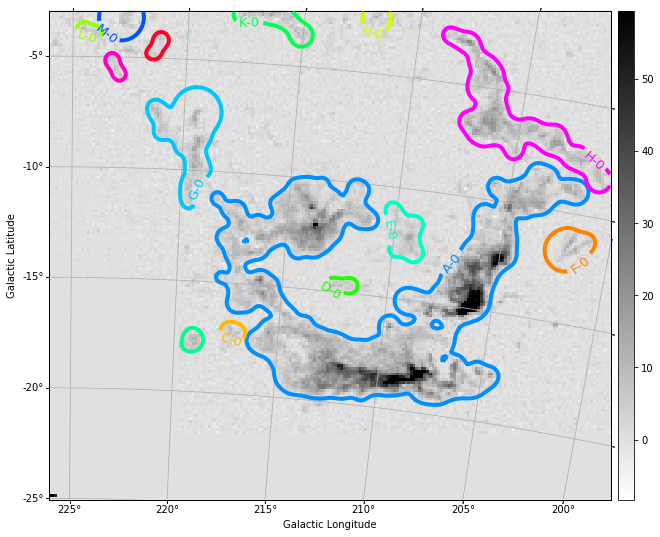

In [13]:
gp.ce_plot(hdmc, wcs=hdmc.wcs)

In [13]:
hdmc.visualize()

interactive(children=(Text(value='', description='split'), Text(value='', description='join1'), Text(value='',…

In [24]:
hdmc.compute_stats()

,Flux [Jy/Beam],Right Ascension,Declination
A-0,2179.484496,210deg04m15.5738s,-16deg03m10.0685s
B-0,31.629647,219deg07m11.9852s,-17deg43m12.6262s
C-0,22.152612,217deg16m13.3874s,-17deg14m03.6129s
D-0,18.702571,212deg13m57.9007s,-14deg40m23.9544s
E-0,18.376659,209deg38m40.9913s,-12deg04m11.6066s
F-0,36.463717,201deg41m31.1611s,-11deg28m32.6076s
G-0,32.277895,219deg33m51.3429s,-9deg40m03.5967s
H-0,187.067520,204deg55m11.2807s,-6deg47m54.8505s
I-0,21.565744,223deg06m23.4612s,-5deg29m21.4423s
J-0,14.181749,221deg15m04.5271s,-4deg27m23.677s


***
### Remaining Tasks
1. Implement an Agglomeration algorithm for more general geometries (not only elipsoidal).
    * Bhattacharyya distances between mixtures.

2. Define a set of test images and cubes ($5$ approx).

    a. __TBD:__ Use an image with known distribution of CE or a synthetic image?
 
2. Define the set of experiments to perform.
    
    a. __Computational__. 1) Accuracy, 2) Flux-control, Computational improvement respect to the previus version of HDMC (time and accuracy). __TBD__: Experiments to show that more degrees of freedom for each Gaussian it is not worthy. (k sigma experiment). 
    b. __Astronomical__. 1) Capacity to identify multi-level structures: Structural Analysis on images, Structural Analysis on cubes. 2) Capabilities to identify known structures.

***